In [53]:
# Dependências
!pip install networkx
!pip install node2vec
!pip install scikit-learn
!pip install matplotlib
!pip install pandas

In [54]:
import pandas as pd
import numpy as np
import networkx as nx
from node2vec import Node2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

# Definir seed para reprodutibilidade
random.seed(42)
np.random.seed(42)

In [ ]:
import sys, importlib
print('executable:', sys.executable)
import gensim
importlib.reload(gensim)
from gensim.models import Word2Vec
print('gensim', gensim.__version__)
print('Word2Vec.__init__ repr:', Word2Vec.__init__)

executable: /home/johnpenguim/anaconda3/bin/python
gensim version: 4.4.0
Word2Vec init signature: <function _patched_w2v_init at 0x7f35f411a0c0>


In [56]:
# Dados simulados com base nas relações de proximidade (cognatos) do artigo
data = {
    'Source': ['Arin', 'Arin', 'Ket', 'Arin', 'Arin', 'Xiongnú', 'Arin', 'Ket'],
    'Target': ['Ket', 'Yugh', 'Yugh', 'Xiongnú', 'Huns', 'Huns', 'Proto-Turkic', 'Proto-Mongolic'],
    'Weight': [10, 8, 9, 12, 11, 13, 3, 2] # Peso = Força da Proximidade/Cognato
}
df_edges = pd.DataFrame(data)

# Lista de todas as línguas (nós)
languages = sorted(list(set(df_edges['Source']) | set(df_edges['Target'])))

Número de Nós (Línguas): 7
Número de Arestas (Relações): 8


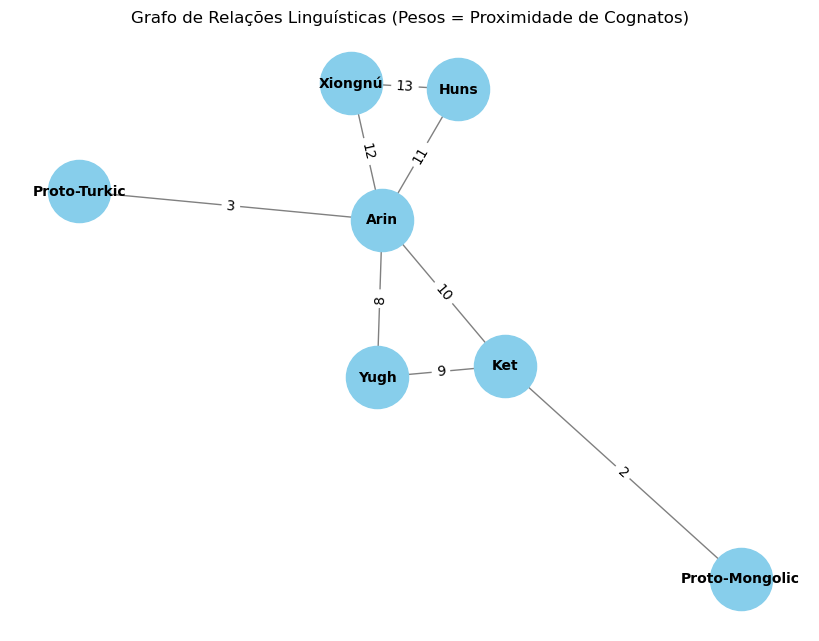

In [57]:
# 1. Crie um grafo não direcionado
G = nx.Graph()

# 2. Adicione as arestas com seus pesos
for index, row in df_edges.iterrows():
    # Note: Node2Vec funciona com pesos nos grafos NetworkX se você usar 'weight'
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

print(f"Número de Nós (Línguas): {G.number_of_nodes()}")
print(f"Número de Arestas (Relações): {G.number_of_edges()}")

# Visualização inicial do Grafo (Opcional, mas útil)
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, k=0.5, seed=42)  # Layout para melhor visualização
nx.draw(G, pos, 
        with_labels=True, 
        node_size=2000, 
        node_color='skyblue', 
        font_size=10, 
        font_weight='bold', 
        edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Grafo de Relações Linguísticas (Pesos = Proximidade de Cognatos)")
plt.show()

In [58]:
# 1. Inicialize o Node2Vec
# Note: Node2Vec automaticamente usa os pesos (weights) do NetworkX se 'weighted=True'
node2vec = Node2Vec(G, 
                    dimensions=64,           # Dimensão do vetor embedding
                    walk_length=20,          # Comprimento dos passeios
                    num_walks=200,           # Número de passeios por nó
                    p=1, q=1,                # Hiperparâmetros de busca (p=1, q=1 para uma busca mais balanceada)
                    weight_key='weight',      # Usar a chave 'weight' para pesos no NetworkX
                    workers=4)

# 2. Treine o modelo Word2Vec (skip-gram) para gerar os embeddings
# 'epochs' e 'min_count' são parâmetros do Word2Vec
# Compatibility shim: if gensim>=4 is installed, Word2Vec expects 'vector_size' instead of 'size'.
# node2vec calls Word2Vec with 'size' (older gensim). Patch Word2Vec.__init__ at runtime to accept 'size'.

Generating walks (CPU: 3): 100%|██████████| 50/50 [00:01<00:00, 26.37it/s]


In [ ]:
import gensim
from gensim.models import Word2Vec

w2v_kwargs = dict(window=10, min_count=1, epochs=20)
# gensim 4+ expects `vector_size`; older gensim uses `size`
try:
    major = int(gensim.__version__.split('.')[0])
except Exception:
    major = 4

if major >= 4:
    w2v_kwargs['vector_size'] = node2vec.dimensions
else:
    w2v_kwargs['size'] = node2vec.dimensions

# Use Word2Vec directly on the random walks produced by Node2Vec
model = Word2Vec(node2vec.walks, **w2v_kwargs)

# 3. Extraia os embeddings
embeddings = {}
for node in G.nodes():
    try:
        embeddings[node] = model.wv[node]
    except KeyError:
        embeddings[node] = model.wv[str(node)]

# Crie um DataFrame dos embeddings
embedding_df = pd.DataFrame.from_dict(embeddings, orient='index')
embedding_df.index.name = 'Language'
print("\n--- Embeddings Gerados ---")
print(embedding_df.head())

RecursionError: maximum recursion depth exceeded